<h1> Vypracovali: Dominik Klušák, Richard Kello (51%,49%)</h1>

In [51]:
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from scipy import stats
import scipy
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer



def repair_ds(ds_stations, ds_ms):

    # zjednotenie hodnot
    ds_stations["QoS"].replace(to_replace="accep", inplace=True, value="acceptable")
    ds_stations["QoS"].replace(to_replace="maitennce", inplace=True, value="maintenance")
    
    
def encode_ds(ds):
    map_QoS={
        'excellent':5, 'acceptable':2, 'maintenance':1, 'average':3, 'building':0,
        'good':4
    }
    ds["QoS"] = ds["QoS"].map(map_QoS)

def delete_outik(ds, cols = None):
    new_ds = ds.copy()
    if cols is None:
        cols = ds.columns

    for col in cols:
        new_ds[col] = ds[col].mask(np.abs(stats.zscore(ds[col])) > 2.8, np.nan)

    new_ds.dropna(inplace=True)
    return new_ds

def replace_mean_outik(ds, cols = None):
    new_ds = ds.copy()
    if cols is None:
        cols = ds.columns

    for col in cols:
        new_ds[col] = ds[col].mask(np.abs(stats.zscore(ds[col])) > 2.8, ds[col].mean())

    return new_ds


def knn_imp(ds):
    
    new_ds = ds.copy()
    imputer = KNNImputer(n_neighbors=5)
    new_ds = pd.DataFrame(imputer.fit_transform(new_ds),columns = new_ds.columns)
    
    return new_ds
    

def log_n(data, n):
    for i in range(n):
        data = np.log(data + 1)
    return data


def sqr_root(data, n):
    for i in range(n):
        data = np.sqrt(data)
    return data

def cb_root(data, n):
    for i in range(n):
        data = np.cbrt(data)
    return data


class Transformer_Last_Knight(BaseEstimator, TransformerMixin):
    
    def __init__(self, transform_type = "sqr_root"): #Argumenty pre cunstom transfer(Transformer_Last_Knight),
        self.transform_type = transform_type         #píšeme do transform_type

        
    def transform(self, X):
        if self.transform_type == "cb_root":
            X["C2H3NO5"] = cb_root(X["C2H3NO5"], 1)
        
        if self.transform_type == "sqr_root":
            X["C2H3NO5"] = sqr_root(X["C2H3NO5"], 2)
        
        return np.array(X)
    
    
    def fit(self, X, y = None):
        return self

<h1> Fáza 2 - Predspracovanie údajov </h1>
<h2> 1. Integrácia a čistenie dát | 3. Výber atributov pre strojové učenie </h2><br>
Čiastočnému čisteniu dát sme sa venovali už aj vo fáze predtým, no v tejto sme si vyskúšali rôzne métody nahradenia chýbajúcich hodnôt a taktiež sme sa pozreli aj na vychýlené hodnoty

<b>Pôvodné dáta:</b>

In [52]:
ds_stations=pd.read_csv("./data/stations.csv", sep="\t")
ds_ms=pd.read_csv("./data/measurements.csv", sep="\t")

repair_ds(ds_stations, ds_ms)
ds_ms.describe()

,H2CO,CH4,PM10,NOx,PRES,PM2.5,CO,O3,PAHs,latitude,C2H3NO5,Pb,warning,CFCs,TEMP,SO2,longitude,NH3
count,12025.000000,12024.000000,12024.000000,12025.000000,12074.000000,12026.000000,12026.000000,12025.000000,12024.000000,12074.000000,12026.000000,12023.000000,12025.000000,12024.000000,12025.000000,12026.000000,12074.000000,12026.000000
mean,52.857252,9.719246,10.216462,9.467375,1123.804506,9.485141,7.643612,10.240201,8.958883,29.335770,0.453932,51.820077,0.596507,51.905513,14.995120,8.951263,10.953184,8.945004
std,13.234231,1.827142,1.513753,1.750035,43.115052,1.713246,1.335028,1.278510,1.000493,23.277563,1.854365,13.110565,0.490618,13.522097,9.976215,0.986925,73.000249,0.992803
min,0.000000,0.000000,2.588530,2.217090,1050.006790,2.760530,2.475540,5.027350,4.781580,-38.653330,0.000000,0.000000,0.000000,0.000000,-22.445920,5.368090,-156.474320,4.585820
25%,43.966950,8.833540,9.236083,8.498710,1086.371800,8.284360,6.739640,9.396020,8.295637,14.865755,0.054865,43.070275,0.000000,42.775243,8.272030,8.295255,-60.473890,8.272158
50%,52.982980,9.958215,10.234975,9.778220,1123.344405,9.666975,7.647120,10.241770,8.968050,36.767750,0.142415,51.799350,1.000000,51.890820,15.070170,8.944460,9.152140,8.964215
75%,61.767260,10.909530,11.191685,10.686690,1160.688075,10.719205,8.549112,11.069280,9.625700,46.705500,0.362095,60.816005,1.000000,61.015100,21.744170,9.604360,72.773463,9.605145
max,100.000000,16.051470,16.827720,14.393620,1199.979550,15.547060,13.676690,16.126770,13.583310,68.798330,100.000000,100.000000,1.000000,100.000000,52.722020,13.169880,178.004170,13.011030


<b>Odstránenie hodnôt chýbajúcich hodnôt tým že ich vyhodíme:</b>

In [53]:
ds_ms_droped_nan = pd.read_csv("./data/measurements.csv", sep="\t")
ds_ms_droped_nan.dropna(inplace=True)
ds_ms_droped_nan.describe()

,H2CO,CH4,PM10,NOx,PRES,PM2.5,CO,O3,PAHs,latitude,C2H3NO5,Pb,warning,CFCs,TEMP,SO2,longitude,NH3
count,11359.000000,11359.000000,11359.000000,11359.000000,11359.000000,11359.000000,11359.000000,11359.000000,11359.000000,11359.000000,11359.000000,11359.000000,11359.000000,11359.000000,11359.000000,11359.000000,11359.000000,11359.000000
mean,52.835142,9.716621,10.217717,9.467816,1123.858687,9.478802,7.640748,10.241318,8.957588,29.354296,0.456406,51.783326,0.597588,51.954232,15.003763,8.951059,10.869923,8.943891
std,13.233265,1.826411,1.515621,1.755504,43.144056,1.713763,1.338603,1.280759,0.999552,23.362887,1.892683,13.110815,0.490406,13.528166,9.968696,0.983378,72.916836,0.994353
min,0.000000,0.000000,2.588530,2.217090,1050.006790,2.760530,2.475540,5.027350,4.781580,-38.653330,0.000000,0.000000,0.000000,0.000000,-22.445920,5.368090,-156.474320,4.585820
25%,43.878790,8.832485,9.231600,8.495310,1086.374955,8.277845,6.736660,9.396070,8.293025,14.954720,0.054790,43.044980,0.000000,42.818455,8.238915,8.297600,-60.473890,8.270760
50%,52.923350,9.950670,10.231980,9.778920,1123.434360,9.658710,7.643140,10.242440,8.965780,36.821670,0.142020,51.750330,1.000000,51.956930,15.064010,8.944860,9.150130,8.963240
75%,61.745075,10.908170,11.199520,10.687205,1160.798110,10.714490,8.546910,11.065880,9.625045,46.754510,0.364260,60.783500,1.000000,61.041805,21.748250,9.603460,72.442440,9.606900
max,100.000000,16.051470,16.827720,14.393620,1199.979550,15.547060,13.676690,16.126770,13.583310,68.798330,100.000000,100.000000,1.000000,100.000000,52.722020,13.169880,178.004170,13.011030


<b> Nahradenie chýbajúcich hôdnôt medianom: </b>

In [54]:
ds_ms_replace_mean = pd.read_csv("./data/measurements.csv", sep="\t")
ds_ms_replace_mean.fillna(ds_ms_replace_mean.mean(), inplace=True)
ds_ms_replace_mean.describe()

,H2CO,CH4,PM10,NOx,PRES,PM2.5,CO,O3,PAHs,latitude,C2H3NO5,Pb,warning,CFCs,TEMP,SO2,longitude,NH3
count,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000
mean,52.857252,9.719246,10.216462,9.467375,1123.804506,9.485141,7.643612,10.240201,8.958883,29.335770,0.453932,51.820077,0.596507,51.905513,14.995120,8.951263,10.953184,8.945004
std,13.207348,1.823354,1.510615,1.746480,43.115052,1.709837,1.332371,1.275912,0.998419,23.277563,1.850675,13.082844,0.489622,13.494067,9.955950,0.984961,73.000249,0.990828
min,0.000000,0.000000,2.588530,2.217090,1050.006790,2.760530,2.475540,5.027350,4.781580,-38.653330,0.000000,0.000000,0.000000,0.000000,-22.445920,5.368090,-156.474320,4.585820
25%,44.018995,8.839835,9.239490,8.504528,1086.371800,8.290295,6.745635,9.397905,8.300828,14.865755,0.055080,43.109120,0.000000,42.809185,8.303583,8.297570,-60.473890,8.274653
50%,52.921120,9.950420,10.228530,9.768985,1123.344405,9.657850,7.643612,10.240201,8.963085,36.767750,0.143410,51.820077,1.000000,51.905513,15.031635,8.948740,9.152140,8.959210
75%,61.736240,10.905580,11.188075,10.682153,1160.688075,10.715808,8.544313,11.064938,9.623307,46.705500,0.368395,60.780260,1.000000,60.986725,21.713880,9.602330,72.773463,9.601577
max,100.000000,16.051470,16.827720,14.393620,1199.979550,15.547060,13.676690,16.126770,13.583310,68.798330,100.000000,100.000000,1.000000,100.000000,52.722020,13.169880,178.004170,13.011030


<b> Nahradenie chýbajúcich hodnôt pomocou kNN: </b>

In [55]:
ds_ms_replace_knn = pd.read_csv("./data/measurements.csv", sep="\t")
ds_ms_replace_knn.fillna(knn_imp(ds_ms_replace_knn), inplace=True)
ds_ms_replace_knn.describe()

,H2CO,CH4,PM10,NOx,PRES,PM2.5,CO,O3,PAHs,latitude,C2H3NO5,Pb,warning,CFCs,TEMP,SO2,longitude,NH3
count,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000,12074.000000
mean,52.853365,9.718637,10.216239,9.467610,1123.804506,9.485206,7.643465,10.239710,8.958787,29.335770,0.453554,51.822075,0.596488,51.907235,14.997895,8.951167,10.953184,8.945320
std,13.214130,1.824137,1.511256,1.746872,43.115052,1.710578,1.332836,1.276491,0.998810,23.277563,1.850777,13.089760,0.489804,13.498680,9.959926,0.985417,73.000249,0.991293
min,0.000000,0.000000,2.588530,2.217090,1050.006790,2.760530,2.475540,5.027350,4.781580,-38.653330,0.000000,0.000000,0.000000,0.000000,-22.445920,5.368090,-156.474320,4.585820
25%,43.992508,8.835250,9.239085,8.504280,1086.371800,8.288712,6.744815,9.396933,8.298570,14.865755,0.055080,43.097440,0.000000,42.801982,8.291580,8.297050,-60.473890,8.274415
50%,52.977620,9.954610,10.233875,9.777135,1123.344405,9.666270,7.646770,10.240905,8.966835,36.767750,0.143025,51.802160,1.000000,51.890820,15.071050,8.943690,9.152140,8.964215
75%,61.745885,10.906478,11.188773,10.682350,1160.688075,10.716542,8.545280,11.066803,9.623930,46.705500,0.363020,60.795010,1.000000,60.992737,21.720547,9.603260,72.773463,9.603140
max,100.000000,16.051470,16.827720,14.393620,1199.979550,15.547060,13.676690,16.126770,13.583310,68.798330,100.000000,100.000000,1.000000,100.000000,52.722020,13.169880,178.004170,13.011030


Vidíme že ani v jednom prípade sa nám dáta signifikatne nezmenili a teda pre naše pokračovanie si vyberieme časť kde sme vyhodili všetky <b><i>missing values</i></b>

In [56]:
ppt=pd.read_csv("./data/stations.csv", sep="\t")
ppt.sort_values("revision", inplace=True)
ppt.drop_duplicates(subset = ["latitude", "longitude"], keep = "last", inplace = True)

ds = pd.merge(ds_ms_droped_nan, ppt, how="left", on = ["longitude", "latitude"])

ds.drop(["location", "station", "revision", "warning", "PRES", "latitude", "longitude"],axis=1, inplace = True)
encode_ds(ds)

#ds.drop_duplicates(subset = ["latitude", "longitude"], keep = "last", inplace = True)
ds.dropna(inplace = True)
cut_cols = ["QoS"]
value_cols = list(set(ds.columns) - set(cut_cols))
ds.describe()

,H2CO,CH4,PM10,NOx,PM2.5,CO,O3,PAHs,C2H3NO5,Pb,CFCs,TEMP,SO2,NH3,QoS
count,9077.000000,9077.000000,9077.000000,9077.000000,9077.000000,9077.000000,9077.000000,9077.000000,9077.000000,9077.000000,9077.000000,9077.000000,9077.000000,9077.000000,9077.000000
mean,52.898484,9.726562,10.204212,9.471709,9.479362,7.657516,10.241780,8.954760,0.439210,51.864059,51.920480,15.068303,8.950438,8.947192,3.171643
std,13.246145,1.832805,1.517375,1.753759,1.701778,1.343339,1.274057,1.001362,1.535982,13.113687,13.515508,10.035426,0.980330,0.995963,1.639858
min,0.000000,0.000000,2.845670,2.217090,2.760530,2.475540,5.027350,5.445690,0.000000,0.000000,0.000000,-22.445920,5.368090,4.585820,0.000000
25%,43.974330,8.851140,9.212750,8.495010,8.283490,6.747850,9.407020,8.292930,0.053670,43.103310,42.867620,8.287210,8.296890,8.272520,3.000000
50%,53.039050,9.956380,10.222700,9.779210,9.657200,7.654520,10.251610,8.963710,0.139860,51.819820,51.863020,15.136130,8.941410,8.962060,4.000000
75%,61.789770,10.914570,11.189030,10.687950,10.709830,8.556270,11.055650,9.622670,0.361000,60.750880,60.987400,21.801340,9.603450,9.612290,4.000000
max,100.000000,16.051470,16.615200,14.393620,15.547060,13.676690,15.870980,13.583310,80.851900,100.000000,100.000000,52.722020,13.169880,12.862590,5.000000


Najprv sme zoradili dataset stations podľa stĺpca revisions a následne sme dropli všetky duplicitné záznamy podľa
stanice kde boli získané pričom sme nechali posledný záznam nakoľko to bol najnovší záznam podľa stĺpca revisions.
Potom sme mergli naše datasety, odstránili nepodstatné stĺpce k strojovému učeniu.<br>
<b>Výber dát pre strojove učenie:</b><br>
Tieto dáta sme nechali na základe predošlej fáze kde sme sa pozerali na jednotlivé korelácie voči predikovanej hodnote warning. Ostatné dáta nepotrebné ako PRES, Latitude, Longitude, Location, Station, Revision, sme dropovali. 

C:\Users\Dominik\iau\env\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

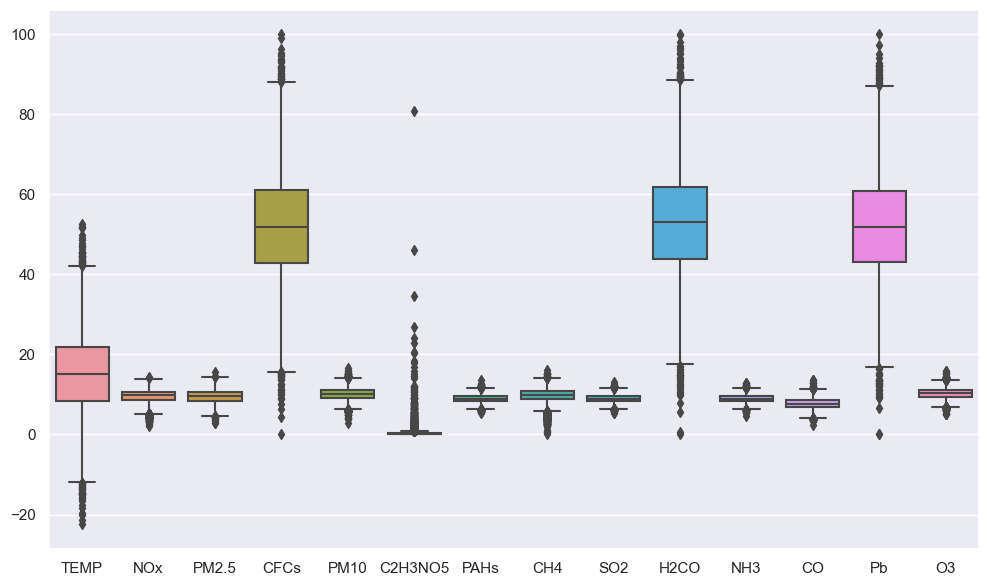

In [57]:
sns.set(rc={'figure.figsize':(12,7)})
sns.boxplot(data = ds[value_cols])

Tento graf nám však veľký prehľad nepriniesol keďže jednotlivé hodnoty majú rôzný rozsah. Dáta normalizujeme teda pomocou <b><i>MinMax</b></i> škálovania teda hodnoty v rozpetí <0,1> ktoré najviac vyhovujú strojovému učeniu. 

C:\Users\Dominik\iau\env\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

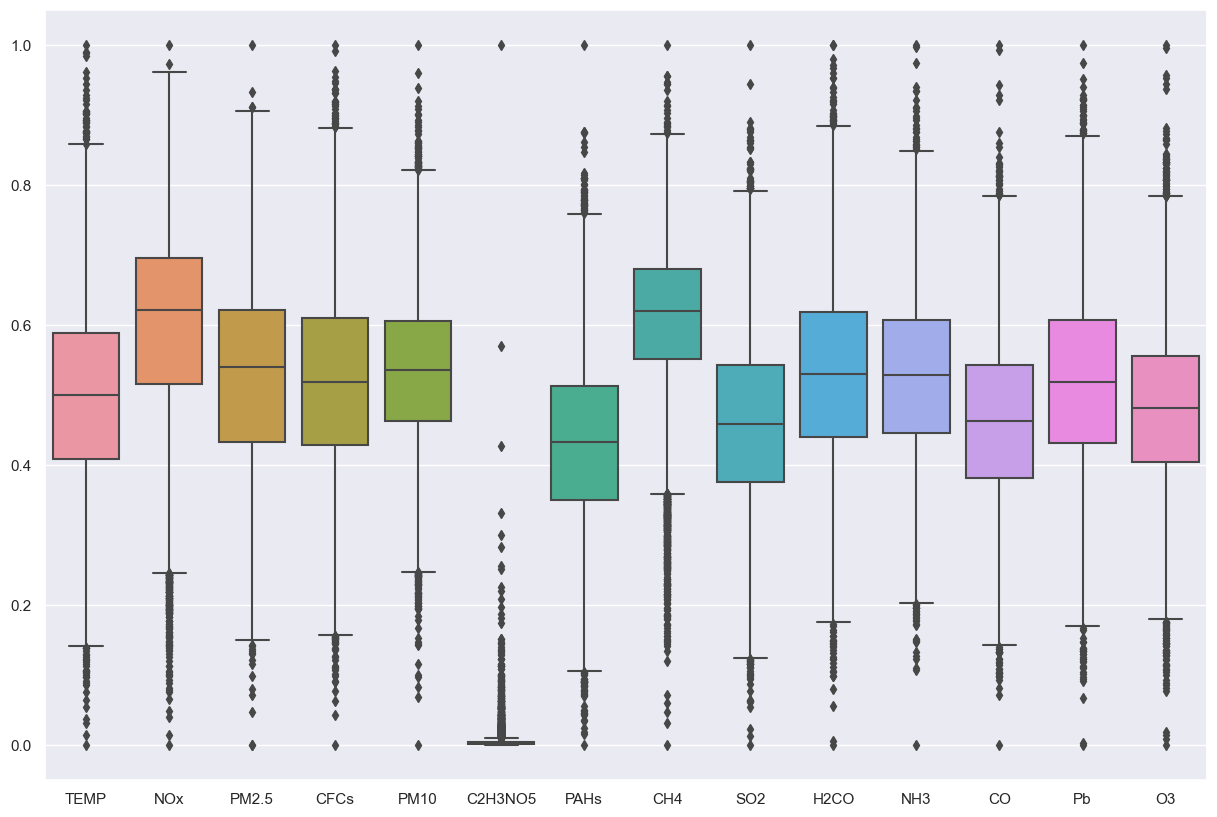

In [58]:
scaler = MinMaxScaler()
ds_scaled = pd.DataFrame(scaler.fit_transform(ds[value_cols]), columns=value_cols)

sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(data=ds_scaled)

Na naškalovaných dátach už môžeme vidieť že niektoré hodnoty máme vychylené až moc ako napríklad <b><i>C2H3NO5</b></i>.
Samotnú detekciu outlierov zisťujeme podľa z-score čo predstavuje štandardnú odchýlku od priemeru.
Pár pokusmi na datasete sme prišli na to že budeme odstráňovať alebo nahrádzať dáta ktoré majú z-score väčšie ako 2.8,
toto z-score sme prispôsobili datasetu aby sme neprišli zároveň o veľa hodnôt ale aj mali odstránených outlierov. <br><br>
<b> Použijeme teda 2 prístupy: Odstránenie outlierov, nahradenie outlierov za priemer. </b>

C:\Users\Dominik\iau\env\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

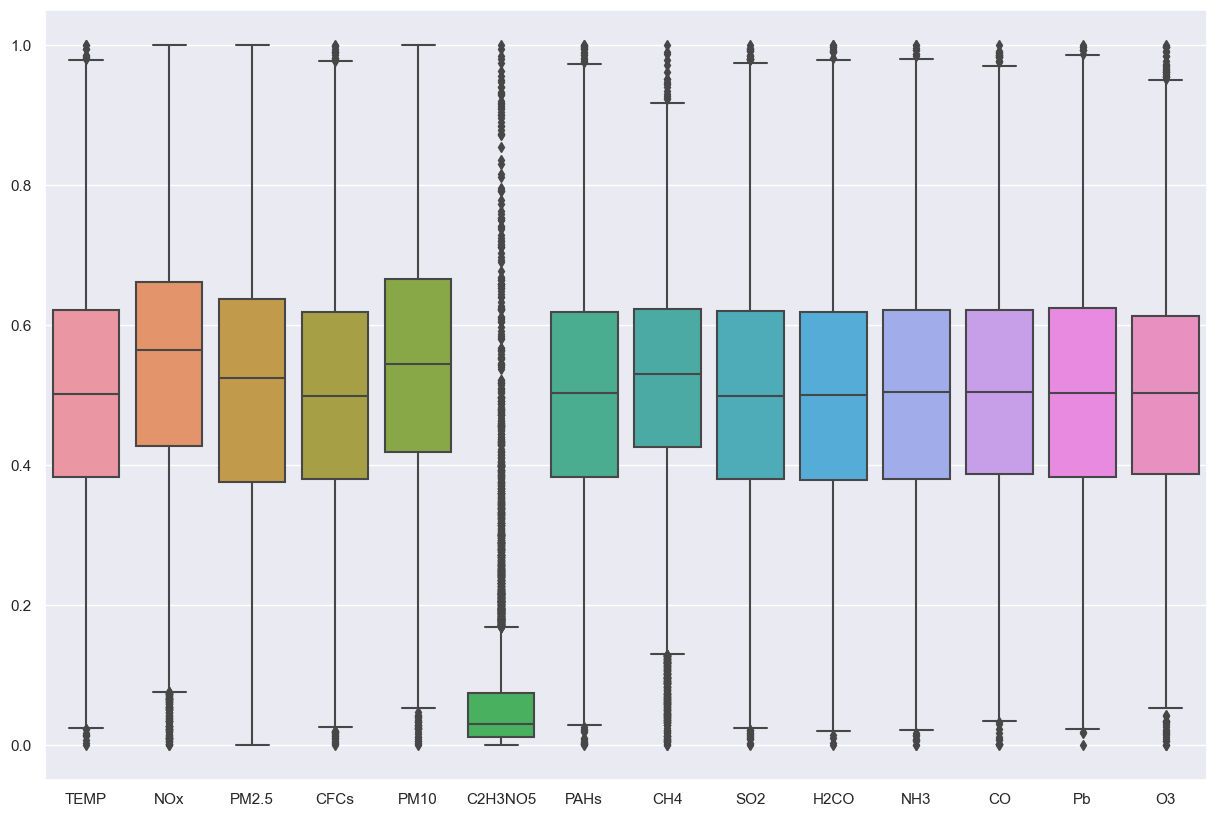

In [59]:
removed_ds = delete_outik(ds_scaled)
removed_ds_scaled = pd.DataFrame(scaler.fit_transform(removed_ds), columns=value_cols)

sns.boxplot(data=removed_ds_scaled)

C:\Users\Dominik\iau\env\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

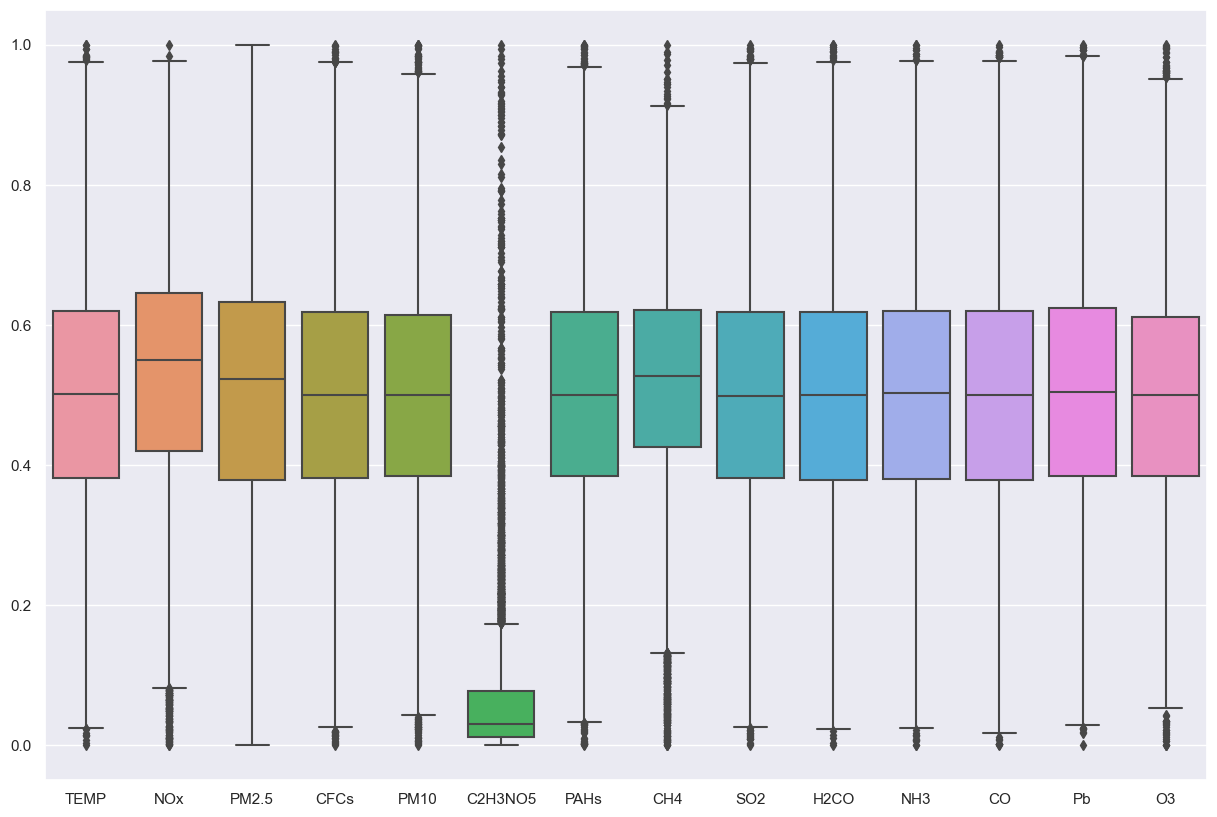

In [60]:
replace_mean_outik_ds = replace_mean_outik(ds_scaled)
replace_mean_outik_scaled = pd.DataFrame(scaler.fit_transform(replace_mean_outik_ds), columns=value_cols)

sns.boxplot(data=replace_mean_outik_scaled)

Z grafov môžme pozorovať že o trochu lepšie fungoval prístup nahradenia outlierov za priemer
preto tieto dáta budeme ďalej používať. <br><br>
<h2>2. Realizácia predspracovania dát</h2><br>
V tejto časti si rozdelíme dáta na 2 množiny a to trénovaciu a testovaciu, rozhodli sme sa pre pomer 2/5 pre testovaciu množinu a 3/5 pre trénovaciu množinu. 

In [61]:
ds = replace_mean_outik(ds_scaled)
ds.to_csv("./data/new_born_data.csv")

In [62]:
# rozdelenie 3/5 train 2/5 test
monster_watermelon = ds.sample(frac = 0.6,random_state = 42)
monster_ultra_fiesta_mango = ds.drop(monster_watermelon.index)
print("Trénovacia množina: {} záznamov".format(len(monster_watermelon)))
print("Testovacia množina: {} záznamov".format(len(monster_ultra_fiesta_mango)))

Trénovacia množina: 5446 záznamov
Testovacia množina: 3631 záznamov


Ešte predtým ako začneme s transformáciu dát pozrieme sa na rozdelenie hodnôt pre jednotlivé stĺpce:

C:\Users\Dominik\AppData\Local\Temp\ipykernel_960\1643657113.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6,3,i)


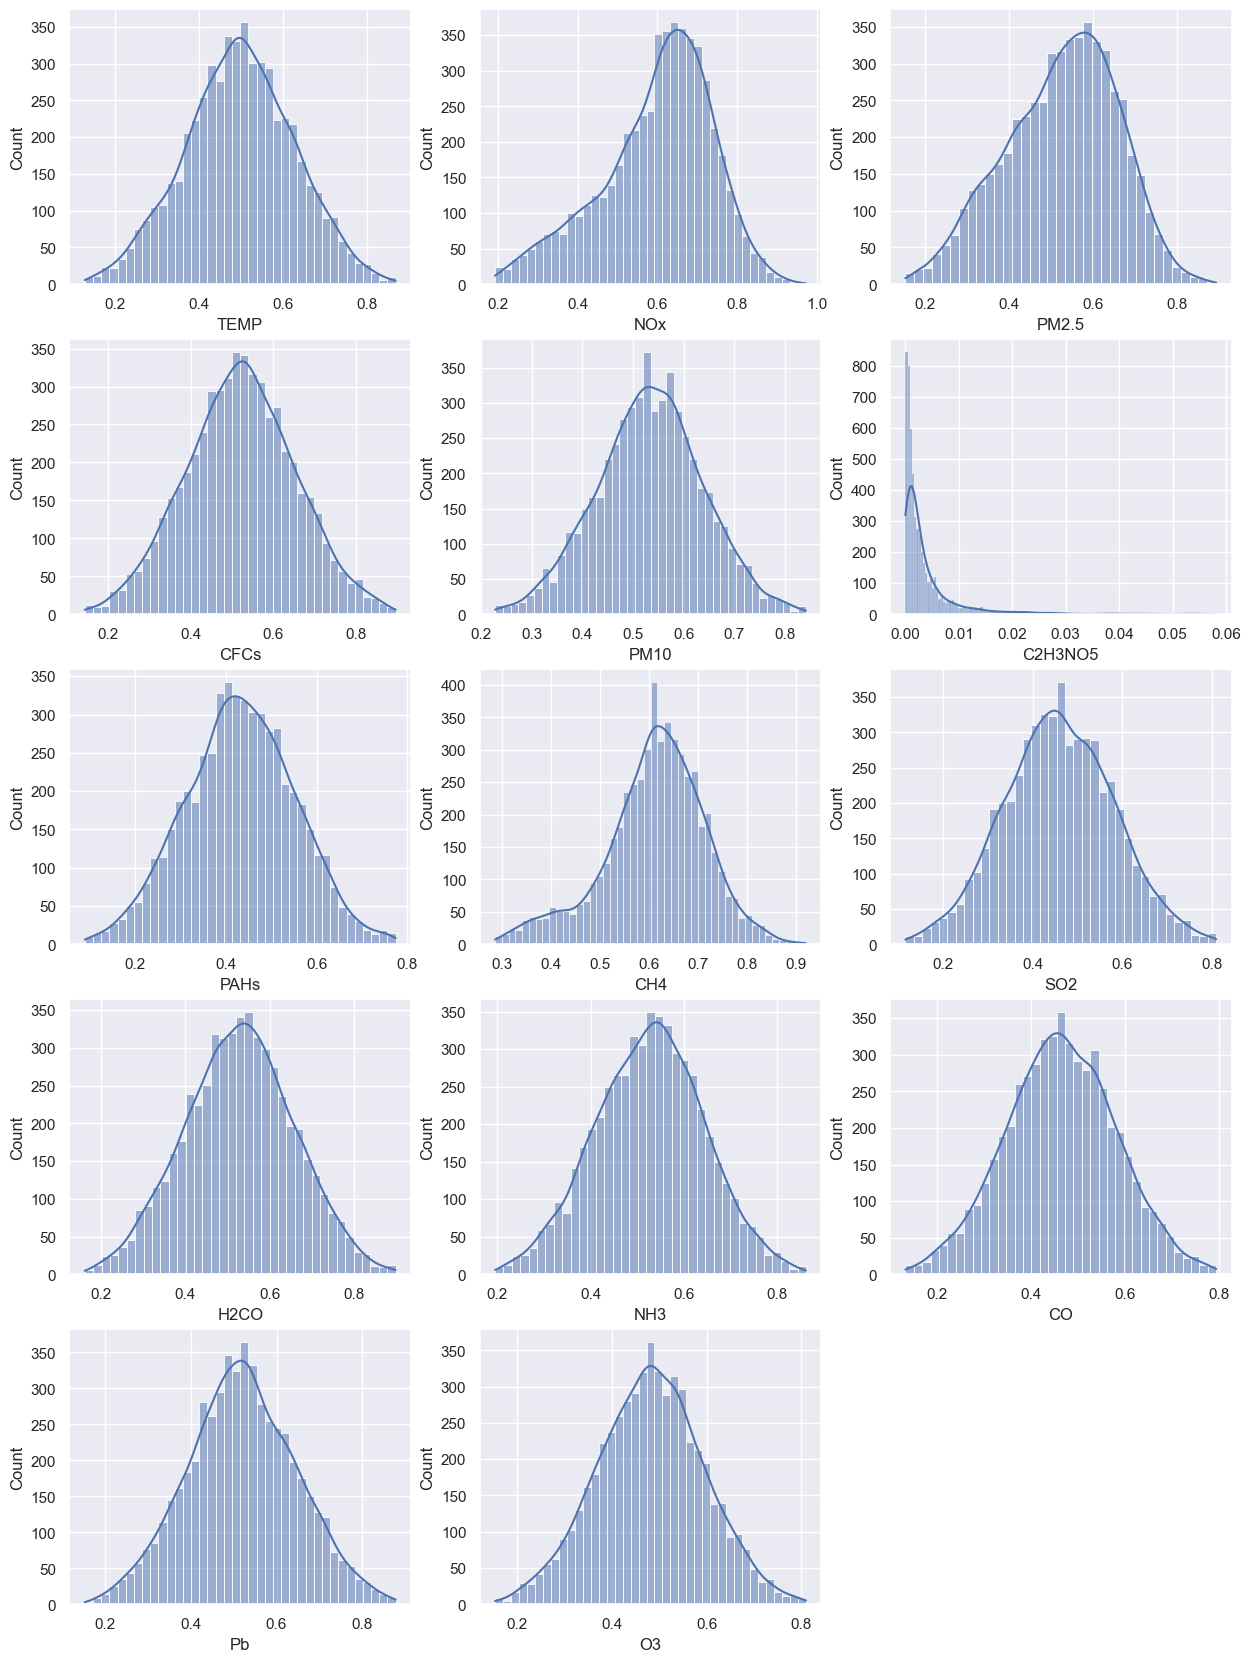

In [63]:
plt.subplots(figsize=(15,25))

for i, column in enumerate(value_cols, 1):
    plt.subplot(6,3,i)
    sns.histplot(monster_watermelon[column], kde=True)

Môžeme vidieť že všetky sĺpce majú normálne rozdelenie až na <b><i>C2H3NO5</b></i>. 
Pri tomto atribúte sa jedná o pozitívne šikmé rozdelenie a preto naň použijeme 2krát <b><i>square root</b></i> a raz<b><i>cube root</b></i> transformáciu. Následne porovnáme výsledky transformácií.

C:\Users\Dominik\AppData\Local\Temp\ipykernel_960\841398314.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6,3,i)


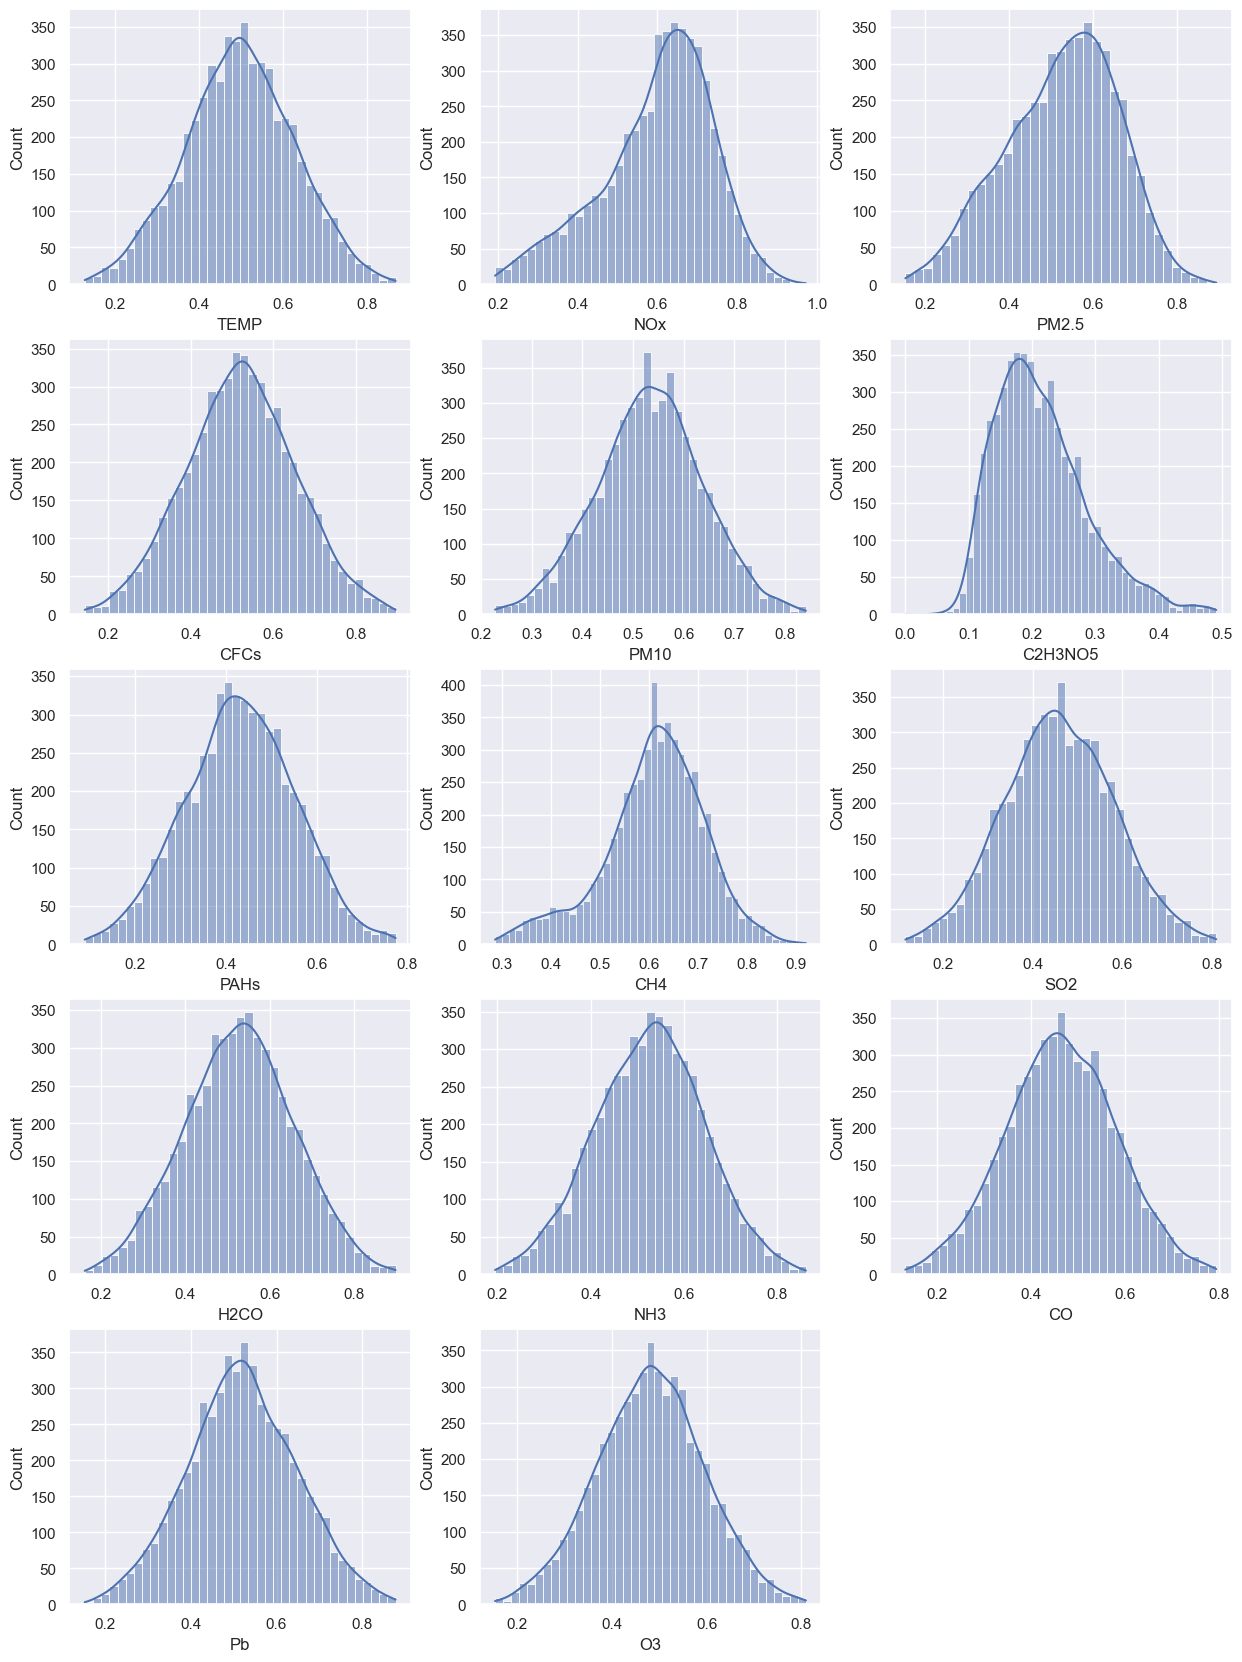

In [64]:
monster_watermelon_test = monster_watermelon.copy()
monster_watermelon_test["C2H3NO5"] = sqr_root(monster_watermelon_test["C2H3NO5"], 2)

plt.subplots(figsize=(15,25))

for i, column in enumerate(value_cols, 1):
    plt.subplot(6,3,i)
    sns.histplot(monster_watermelon_test[column], kde=True)

C:\Users\Dominik\iau\env\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

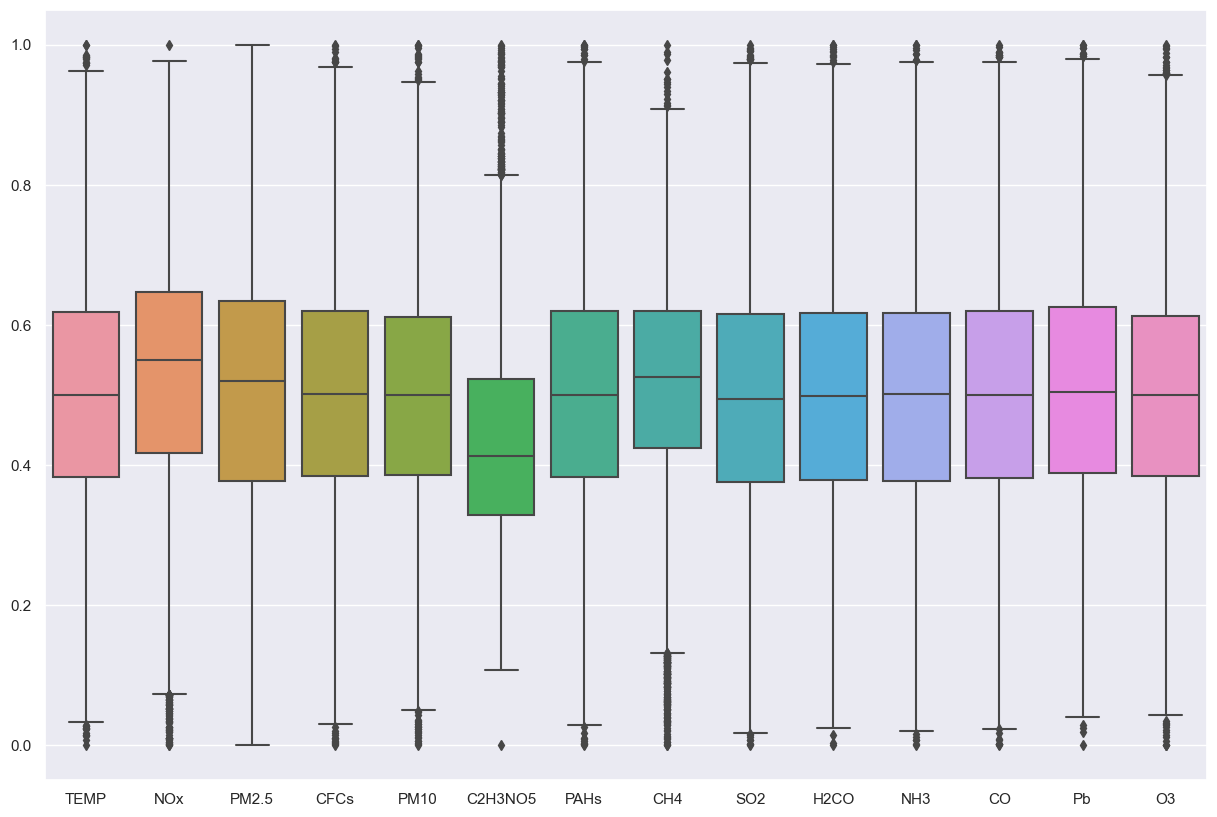

In [65]:
mws = pd.DataFrame(scaler.fit_transform(monster_watermelon_test[value_cols]), columns=value_cols)

sns.boxplot(data = mws)

Vidíme že square root transformáciu sme sa pri atribúte <b><i>C2H3NO5</b></i> priblížili normálnemu rozdeleniu dát. <br>
No pozrieme sa aj na cube root transformáciu:

C:\Users\Dominik\AppData\Local\Temp\ipykernel_960\1172798964.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6,3,i)


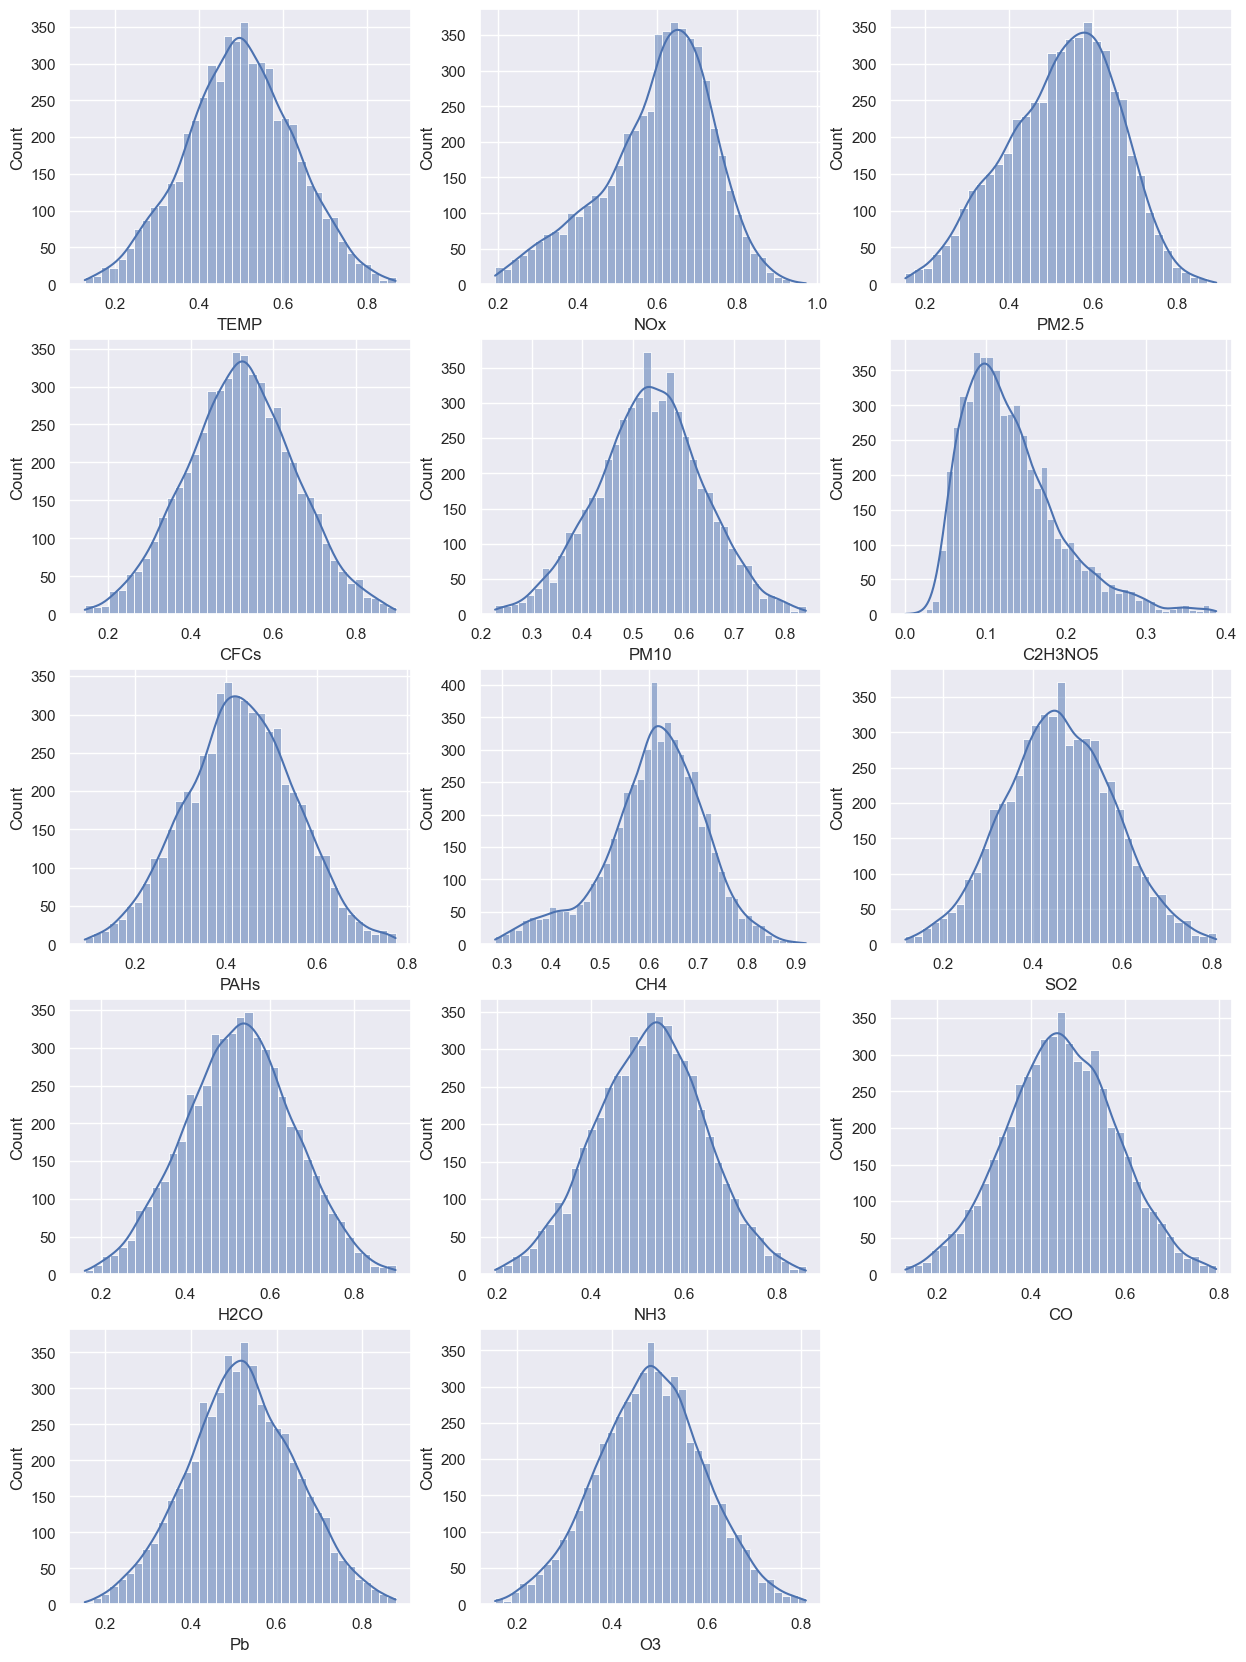

In [66]:
monster_watermelon_test = monster_watermelon.copy()
monster_watermelon_test["C2H3NO5"] = cb_root(monster_watermelon_test["C2H3NO5"], 1)

plt.subplots(figsize=(15,25))

for i, column in enumerate(value_cols, 1):
    plt.subplot(6,3,i)
    sns.histplot(monster_watermelon_test[column], kde=True)

C:\Users\Dominik\iau\env\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

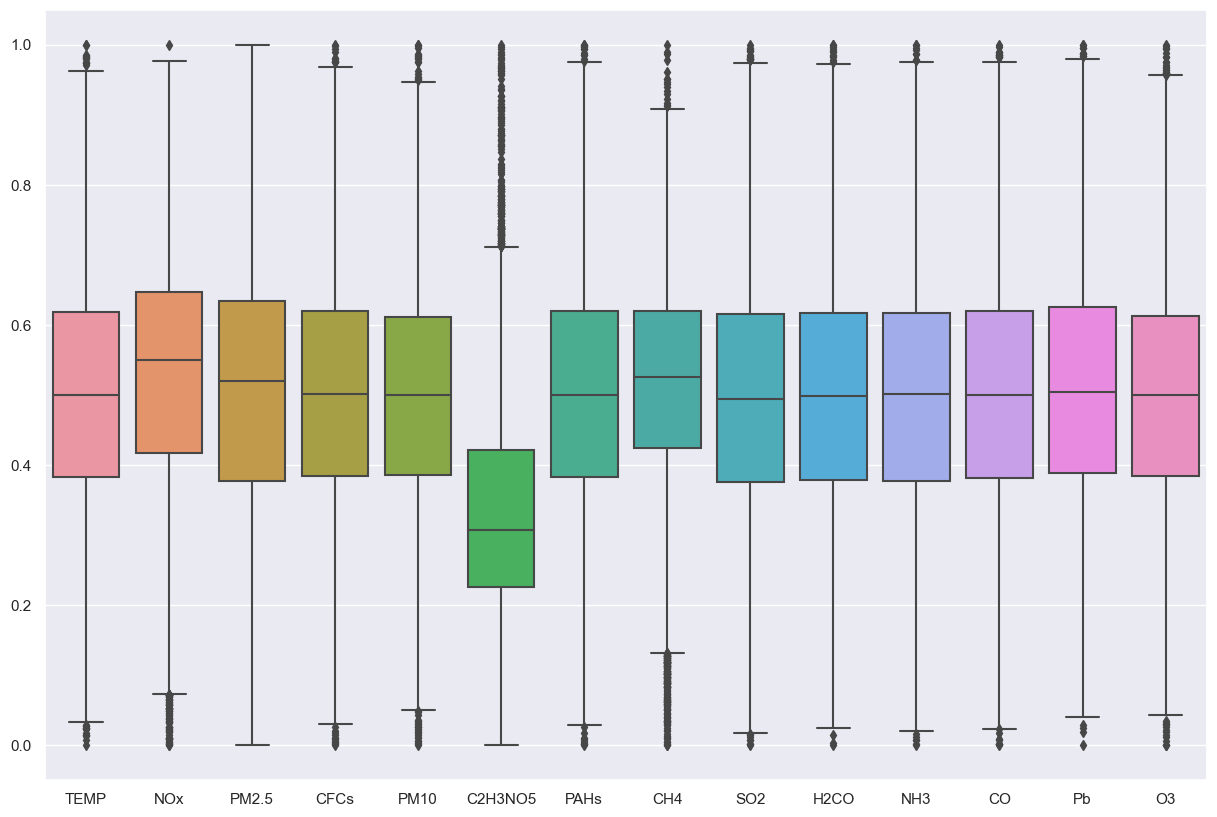

In [67]:
mws = pd.DataFrame(scaler.fit_transform(monster_watermelon_test[value_cols]), columns=value_cols)

sns.boxplot(data = mws)

<b>Porovnanie tranfromácií</b>: Vidíme že pri použití 2-och <b><i>square root</b></i> transformacií sa približujeme už pekne
normálnemu rozdeleniu dát. Zatiaľ čo pre <b><i>cube root</b></i> tranformáciu pre jedno použitie máme stále mierne pozitívne šikmé
rozdelenie, no pri teste z 2-ma <b><i>cube root</b></i> transformáciami sme sa už dostávali zas do negatívne šikmého rozdelenie.<br>
Preto sme sa rozhodli pre 2 krát <b><i>square root</b></i> tranformáciu. 
 

C:\Users\Dominik\iau\env\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

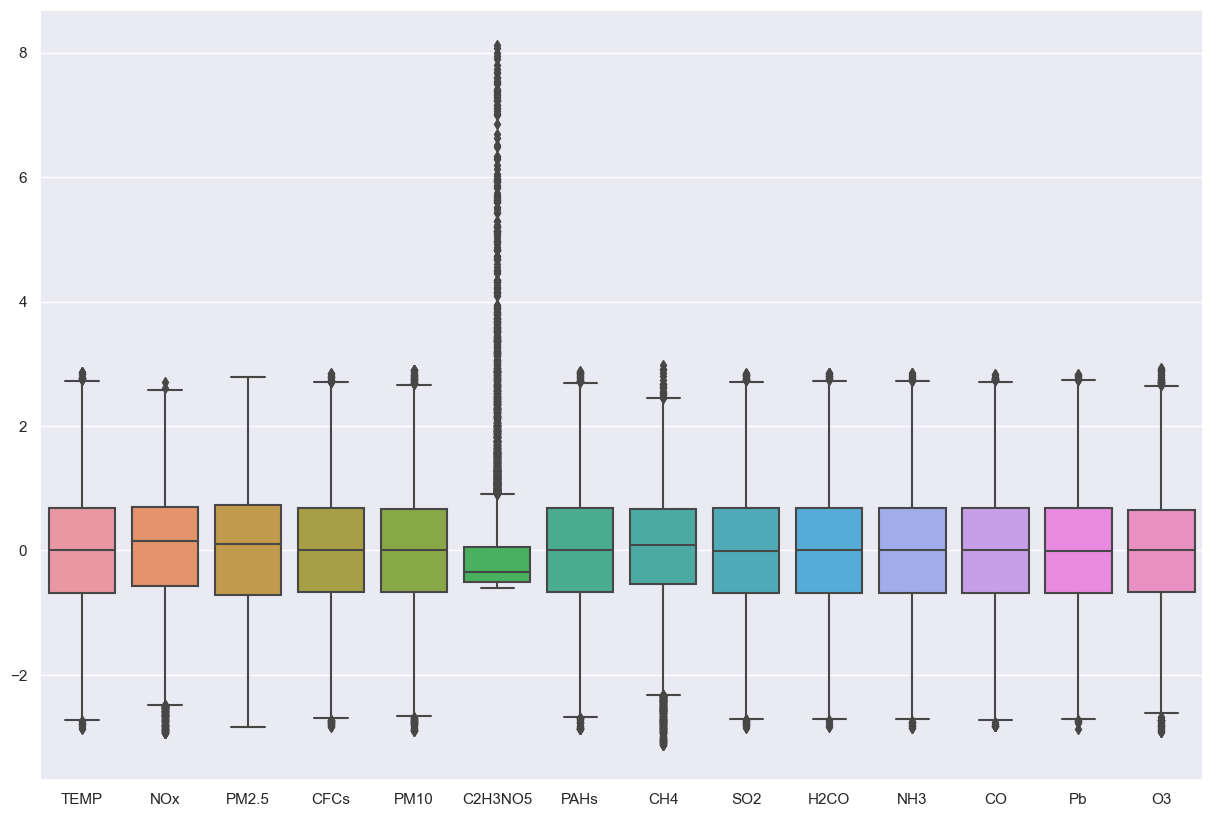

In [68]:
stdscaler = StandardScaler()
ds.describe()
ds = pd.DataFrame(data=stdscaler.fit_transform(ds), columns=ds.columns)
sns.boxplot(data=ds)

Aby sa náš model správal ku všetkým stĺpcom rovnako, musíme sa uistiť že jednotlivé hodnoty sú z rovnakého rozsahu. Vyškalujeme ich teda pomocou <b><i>Standard škálovania</b></i>.

<h2>  4. Replikovateľnosť predspracovania </h2><br>
Vytvorenie pipeline podľa zadania. Pipeline je v <b>Transformer_Last_Knight</b><br><br>
Je možné použitie arguentu na voľbu transformácie a to: <br>
<b>cb_root</b> - tranformácia pomocou cube root <br>
<b>sqr_root</b> - transformácia pomocou square root

In [69]:
ds = pd.read_csv("./data/new_born_data.csv", sep=",")

#treńovacia monster_watermelon 3/5, monster_ultra_fiesta_mango 2/5
monster_watermelon = ds.sample(frac = 0.6,random_state = 42)
monster_ultra_fiesta_mango = ds.drop(monster_watermelon.index)

pipe = Pipeline([
    ("transform", Transformer_Last_Knight()),
    ("scale", StandardScaler())
    ])
pipe.fit_transform(monster_watermelon)

array([[ 0.3853472 ,  0.44839365,  0.10282682, ...,  0.81888587,
        -0.55860985, -0.11727663],
       [ 1.02450671, -0.77383492,  0.13562971, ...,  0.35983009,
         0.76941124, -1.22403311],
       [-1.44581028, -1.93118919, -1.33706995, ..., -0.60790295,
         0.40870827,  0.43514047],
       ...,
       [-0.29985021,  1.10110822, -1.33663524, ...,  0.34371952,
         0.74072497,  0.38565172],
       [-0.99847535,  1.40341827, -2.08016952, ..., -0.31853853,
         0.2897621 ,  0.88709132],
       [ 1.45726297, -0.31966369,  0.76836022, ..., -0.71157228,
         0.10468646,  0.84300953]])